# CNN

Images are high dimensional. So we need a neural network that simplifies this computations.
A series of convolution and pooling during training learn possible abstract representations over their input, which typically decrease its dimensionality.

Layers and their importance:
Conv2D - extract most of the info from image by applying filters. 
Max pooling - to reduce the spatial dimensions of the output volume.
Flatten layer : Convert the 4D output of CNN to 2D 


Dataset can be obtained from Kaggle
https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset

In [3]:
import os
import math
from tensorflow import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Activation

from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import warnings


from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%config Completer.use_jedi = False


In [4]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [5]:
# GPU Configurations
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [16]:
basedir = os.getcwd()
print(basedir)

yoga_train_path = os.path.join("yoga_poses","train") # root for training
yoga_test_path = os.path.join("yoga_poses","TEST") # root for testing


traindir = os.path.join(basedir,yoga_train_path) 
testdir = os.path.join(basedir,yoga_test_path) 

print(traindir)
print(testdir)



C:\Users\laksh\Documents\DAAN570 - Deep Learning
C:\Users\laksh\Documents\DAAN570 - Deep Learning\yoga_poses\train
C:\Users\laksh\Documents\DAAN570 - Deep Learning\yoga_poses\TEST


In [18]:
target_classes = os.listdir(traindir)

def removeCorruptedImagesInFolder(folder, target_classes):
    for cls in target_classes:
        removeCorruptedImages(os.path.join(folder,cls)) 
        
removeCorruptedImagesInFolder(traindir, target_classes)        
removeCorruptedImagesInFolder(testdir, target_classes)    

In [7]:
import cv2
def plot_examples(folder, category):
    """ Plot 5 images of a given category """
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 20))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    
    folder_path = "/".join([folder,category])
    for i in range(5):
        img = cv2.imread('/'.join([folder_path,os.listdir(folder_path)[i]]))
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title('shape:'+str(img.shape))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    plt.show()   

plot_examples(traindir,'downdog')

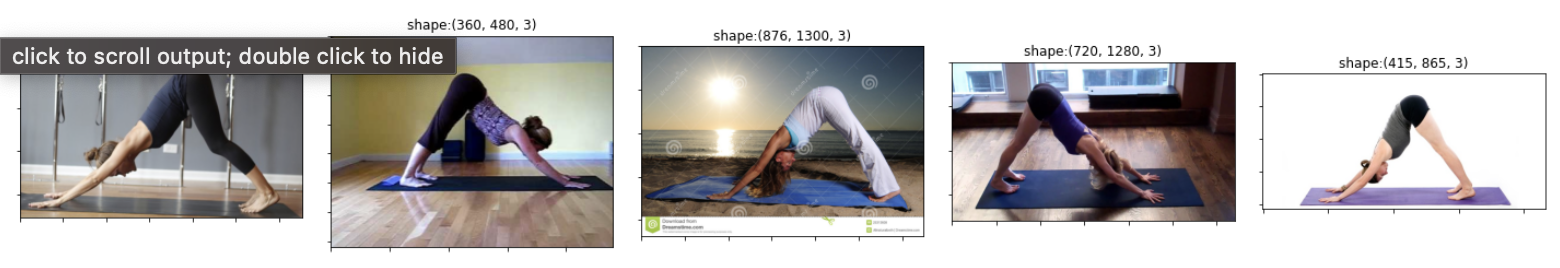

# Count images in each subfolder

In [52]:
def calculate_num_images(dir):
    folders = ([name for name in os.listdir(dir)
    if os.path.isdir(os.path.join(dir, name))]) # get all directories
    #print(folders)
    image_num_dict = {}
    img_count = 0
    for folder in folders:
        contents = os.listdir(os.path.join(dir,folder)) # get list of contents
        image_num_dict[folder] = len(contents)
        img_count +=len(contents)
        #print(folder,len(contents)
        #print(image_num_dict)
    print(image_num_dict)
    return img_count
   

In [53]:
traindir_cnt = calculate_num_images(traindir)
traindir_cnt

{'downdog': 223, 'goddess': 180, 'plank': 266, 'tree': 160, 'warrior2': 252}
1081


In [54]:
testdir_cnt = calculate_num_images(testdir)
testdir_cnt

{'downdog': 97, 'goddess': 80, 'plank': 115, 'tree': 69, 'warrior2': 109}


470

In [22]:
filepath =  os.path.join(traindir,'downdog')
    
from PIL import Image
import glob
image_list = []
for filename in glob.glob('filepath/*.jpg'): #assuming gif
    print(filename)
    im=Image.open(filename)
    image_list.append(im)
    print(im.shape)

# Building CNN network
CNN network comprises of alternate Conv2D and MaxPooling2D layers The number of inputs and outputs depends on our database while the number of layers in between are configurable. Activation function : softmax as we are solving the multi class classification problem.
stack of alternated Conv2D (with relu activation) and MaxPooling2D layers
Flatten layer
Dense layer (with relu activation)
Dropout layer to reduce overfitting
Dense layer (with softmax activation)
Output layer with 3 nodes because we have 3 categories

In [40]:
input_sz = 150
batch_size=64

In [41]:
from tensorflow.keras import layers
from tensorflow.keras import models

# building our convolutional neural network model
   
    
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_sz, input_sz, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

In [42]:
# use adam optimizer to compile
# with categorical crossentropy as our loss
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
# view a summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

# Data Augumentation
We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: data augmentation.

In [57]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 #shear_range=0.2,
                                 #zoom_range=0.2,
                                 horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255) #validation_split = 0.2


print("For Training: ")
train_generator = train_datagen.flow_from_directory(
                  directory = traindir,
                  target_size=(input_sz,input_sz),
                  batch_size=batch_size,
                  shuffle=True,
                  #color_mode="rgb",
                  class_mode='categorical')

print("\nFor Testing: ")
val_generator = test_datagen.flow_from_directory(
                directory = testdir,
                target_size=(input_sz,input_sz),
                batch_size=batch_size,
                shuffle=False,
                #color_mode="rgb",
                class_mode='categorical')

For Training: 
Found 1081 images belonging to 5 classes.

For Testing: 
Found 470 images belonging to 5 classes.


In [58]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
# steps_per_epoch = number of images / batch size  = 1081/64
# validation_steps = test images / batch size

In [61]:
history = model.fit(
      train_generator,
      steps_per_epoch = traindir_cnt//batch_size,
      epochs=10,
      validation_data=val_generator,
      validation_steps=testdir_cnt//batch_size
      )

Epoch 1/10
16/16 [==============================] - 32s 2s/step - loss: 1.6226 - accuracy: 0.2635 - val_loss: 1.5464 - val_accuracy: 0.3929
Epoch 2/10
16/16 [==============================] - 32s 2s/step - loss: 1.4287 - accuracy: 0.4376 - val_loss: 1.2382 - val_accuracy: 0.5491
Epoch 3/10
16/16 [==============================] - 32s 2s/step - loss: 1.2276 - accuracy: 0.5231 - val_loss: 1.1337 - val_accuracy: 0.6317
Epoch 4/10
16/16 [==============================] - 31s 2s/step - loss: 1.1258 - accuracy: 0.5811 - val_loss: 0.7794 - val_accuracy: 0.7054
Epoch 5/10
16/16 [==============================] - 30s 2s/step - loss: 0.9712 - accuracy: 0.6303 - val_loss: 0.6711 - val_accuracy: 0.7656
Epoch 6/10
16/16 [==============================] - 30s 2s/step - loss: 0.8354 - accuracy: 0.6943 - val_loss: 0.5934 - val_accuracy: 0.8036
Epoch 7/10
16/16 [==============================] - 32s 2s/step - loss: 0.7299 - accuracy: 0.7237 - val_loss: 0.5294 - val_accuracy: 0.8259
Epoch 8/10
16/16 [==